In [1]:
#General packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#Data preparation & selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from scipy.stats import chi2_contingency
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

#Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

#Tunning
from sklearn.model_selection import GridSearchCV

#Evaluation
from sklearn.metrics import f1_score

#Importing datasets from moodle
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

### Basic exploration on testing dataset

Exploring incosistencies in the training dataset was done in the previous project and will be shown in the report. For the testing dataset (to be submitted) we will assume the hypothesis that it is already consistent and will explore with .describe, .info and some basic insights.

In [2]:
df_test.describe()

,Cust_ID,Year_Birth,RewardPoints,Comfort,ReceptionSchedule,FoodDrink,Location,Wifi,Amenities,Staff,OnlineBooking,PriceQuality,RoomSpace,CheckOut,Checkin,Cleanliness,BarService
count,5195.000000,5195.000000,5195.000000,5195.000000,5195.000000,5195.000000,5195.000000,5195.000000,5195.000000,5195.000000,5195.000000,5195.000000,5195.000000,5195.000000,5195.000000,5195.000000,5195.000000
mean,32597.000000,1981.590375,5031.689509,2.850626,3.006930,2.884119,3.018094,3.265063,3.388258,3.531473,3.476420,3.454475,3.497401,3.692204,3.357844,3.711646,3.347449
std,1499.811655,15.171122,1026.748250,1.384223,1.518196,1.436115,1.306090,1.307542,1.341690,1.303531,1.298073,1.274584,1.287115,1.155326,1.263340,1.139825,1.299407
min,30000.000000,1941.000000,49.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,31298.500000,1970.000000,4491.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,3.000000,3.000000,3.000000,2.000000
50%,32597.000000,1981.000000,5088.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000
75%,33895.500000,1994.000000,5640.500000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,5.000000,4.000000,5.000000,5.000000,4.000000,5.000000,4.000000
max,35194.000000,2014.000000,6950.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [3]:
df_test.describe(include=['O'])

,Name,Longevity,TypeTravel,RoomType
count,5195,5195,5195,5195
unique,4999,2,2,3
top,Mr. Michael Williams,yes,business,single
freq,6,4267,3512,2398


In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5195 entries, 0 to 5194
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Cust_ID            5195 non-null   int64 
 1   Name               5195 non-null   object
 2   Longevity          5195 non-null   object
 3   Year_Birth         5195 non-null   int64 
 4   TypeTravel         5195 non-null   object
 5   RoomType           5195 non-null   object
 6   RewardPoints       5195 non-null   int64 
 7   Comfort            5195 non-null   int64 
 8   ReceptionSchedule  5195 non-null   int64 
 9   FoodDrink          5195 non-null   int64 
 10  Location           5195 non-null   int64 
 11  Wifi               5195 non-null   int64 
 12  Amenities          5195 non-null   int64 
 13  Staff              5195 non-null   int64 
 14  OnlineBooking      5195 non-null   int64 
 15  PriceQuality       5195 non-null   int64 
 16  RoomSpace          5195 non-null   int64 


Since our goal is to detect earlier possible churn clients, let's see if our train dataset is balanced enough.

In [5]:
Num_Churn=len(df_train[df_train.Churn=="churn"])
Num_NoChurn=len(df_train[df_train.Churn=="nochurn"])
val=[Num_Churn,Num_NoChurn]

Perc_Churn=(float(Num_Churn)/(float(Num_Churn)+float(Num_NoChurn)))*100
print('Churn clients in training dataset: {:.2f}%'.format(Perc_Churn))

Churn clients in training dataset: 45.62%


<AxesSubplot:>

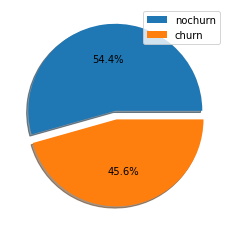

In [6]:
df_train['Churn'].value_counts().plot(kind='pie', autopct='%1.1f%%', shadow=True, explode=[0.05, 0.05], legend=True, ylabel='', labeldistance=None)

In [7]:
df_train.head()

,Cust_ID,Churn,Name,Longevity,Year_Birth,TypeTravel,RoomType,RewardPoints,Comfort,ReceptionSchedule,...,Wifi,Amenities,Staff,OnlineBooking,PriceQuality,RoomSpace,CheckOut,Checkin,Cleanliness,BarService
0,1,churn,Ms. Nicole Clarke,yes,1974.0,business,single,4907,3,4,...,4,3,4,3,3,3,3,4,3,4
1,2,nochurn,Mr. Jesse Scott,yes,1965.0,business,single,6724,1,1,...,5,3,4,5,5,5,5,1,5,2
2,3,churn,Mr. Christopher Carter,yes,1973.0,business,single,4365,3,3,...,1,4,4,3,3,2,3,2,3,1
3,4,nochurn,Ms. Jennifer Morgan,yes,1993.0,leisure,double,3849,1,1,...,4,4,5,4,4,4,4,4,4,3
4,5,nochurn,Mr. Michael White,yes,1989.0,business,single,5376,2,2,...,5,5,5,5,5,3,4,1,3,5


In general exploration, training dataset seems okay, so now we will create a function to treat the original problems in the training dataset and, if applicable, in the testing dataset

### Treating inconsistencies in data

In [8]:
def treat_data(df):
    #Drop inconsistent data, if applicable 
    df = df.drop(df[df.Wifi==6].index)
    df = df.dropna()
    
    #Replacing inconsistent data, if applicable
    df.loc[df["Longevity"]=="y","Longevity"] = "yes"

    #Churn exist only in train and validation dataset, not on test
    if 'Churn' in df:
        df.loc[df["Churn"]=='churn',"Churn"] = 1
        df.loc[df["Churn"]=='nochurn',"Churn"] = 0
        df['Churn'] = df['Churn'].astype(np.int64)

    #Tranforming categorical into numerical
    df["Longevity"] =df["Longevity"].astype("category").cat.codes
    df['TypeTravel'] =df['TypeTravel'].astype('category').cat.codes
    df['RoomType'] =df['RoomType'].astype('category').cat.codes

    return df

### Feature Engineering

Some features will be added to our dataset so we can test them in different models. We start by adding Gender.

In [9]:
def feat_data(df):
    #Average of all answers in the survey 
    df['Overall']=df[['Comfort','ReceptionSchedule','FoodDrink',
        'Location','Wifi','Amenities','Staff','OnlineBooking',
        'PriceQuality','RoomSpace','CheckOut','Checkin','Cleanliness',
        'BarService']].mean(axis=1)

    df["Gender"]=df["Name"].str.split(".",1, expand=True)[0]
    df.loc[df["Gender"]=="Mr","Gender"] = "Male"
    df.loc[df["Gender"]=="Ms","Gender"] = "Female"
    df["Gender"] =df["Gender"].astype("category").cat.codes

    return df

In [10]:
df_train = treat_data(df_train)
df_train = feat_data(df_train)
df_train.head()

,Cust_ID,Churn,Name,Longevity,Year_Birth,TypeTravel,RoomType,RewardPoints,Comfort,ReceptionSchedule,...,Staff,OnlineBooking,PriceQuality,RoomSpace,CheckOut,Checkin,Cleanliness,BarService,Overall,Gender
0,1,1,Ms. Nicole Clarke,1,1974.0,0,1,4907,3,4,...,4,3,3,3,3,4,3,4,3.285714,0
1,2,0,Mr. Jesse Scott,1,1965.0,0,1,6724,1,1,...,4,5,5,5,5,1,5,2,3.142857,1
2,3,1,Mr. Christopher Carter,1,1973.0,0,1,4365,3,3,...,4,3,3,2,3,2,3,1,2.714286,1
3,4,0,Ms. Jennifer Morgan,1,1993.0,1,0,3849,1,1,...,5,4,4,4,4,4,4,3,3.142857,0
4,5,0,Mr. Michael White,1,1989.0,0,1,5376,2,2,...,5,5,5,3,4,1,3,5,3.571429,1


### Feature Selection

We will start by separating categorical from numerical features to use some different Filter Methods appropriated for each one

In [11]:
feats = {'Gender','Overall','Longevity','Year_Birth','TypeTravel','RoomType',
        'RewardPoints','Comfort','ReceptionSchedule','FoodDrink',
        'Location','Wifi','Amenities','Staff','OnlineBooking',
        'PriceQuality','RoomSpace','CheckOut','Checkin','Cleanliness',
        'BarService'}
df_feats = df_train.filter(feats)
df_feats.head()

,RewardPoints,ReceptionSchedule,CheckOut,TypeTravel,Longevity,RoomSpace,Cleanliness,Gender,OnlineBooking,RoomType,...,Overall,BarService,Year_Birth,Checkin,Location,Wifi,Amenities,Comfort,Staff,FoodDrink
0,4907,4,3,0,1,3,3,0,3,1,...,3.285714,4,1974.0,4,4,4,3,3,4,1
1,6724,1,5,0,1,5,5,1,5,1,...,3.142857,2,1965.0,1,1,5,3,1,4,1
2,4365,3,3,0,1,2,3,1,3,1,...,2.714286,1,1973.0,2,3,1,4,3,4,3
3,3849,1,4,1,1,4,4,0,4,0,...,3.142857,3,1993.0,4,1,4,4,1,5,1
4,5376,2,4,0,1,3,3,1,5,1,...,3.571429,5,1989.0,1,2,5,5,2,5,3


In [12]:
num_var = ['Overall','Year_Birth','RewardPoints','Comfort','ReceptionSchedule','FoodDrink','Location','Wifi','Amenities','Staff','OnlineBooking','PriceQuality','RoomSpace','CheckOut','Checkin','Cleanliness','BarService']
cat_var = ['RoomType', 'Gender','Longevity', 'TypeTravel']

df_feats_num = df_feats[num_var]
df_feats_cat = df_feats[cat_var]

Then, we will create a single dataframe with all features together and scaled

In [13]:
def scale_data(df):
    scaler = MinMaxScaler()
    df = pd.DataFrame(scaler.fit_transform(df),columns=df.columns,index=df.index)    
    return df

In [14]:
df_feats = scale_data(df_feats)
df_feats.head()

,RewardPoints,ReceptionSchedule,CheckOut,TypeTravel,Longevity,RoomSpace,Cleanliness,Gender,OnlineBooking,RoomType,...,Overall,BarService,Year_Birth,Checkin,Location,Wifi,Amenities,Comfort,Staff,FoodDrink
0,0.687662,0.8,0.50,0.0,1.0,0.6,0.50,0.0,0.6,0.5,...,0.555556,0.8,0.487179,0.75,0.75,0.8,0.6,0.6,0.75,0.2
1,0.965449,0.2,1.00,0.0,1.0,1.0,1.00,1.0,1.0,0.5,...,0.518519,0.4,0.371795,0.00,0.00,1.0,0.6,0.2,0.75,0.2
2,0.604800,0.6,0.50,0.0,1.0,0.4,0.50,1.0,0.6,0.5,...,0.407407,0.2,0.474359,0.25,0.50,0.2,0.8,0.6,0.75,0.6
3,0.525913,0.2,0.75,1.0,1.0,0.8,0.75,0.0,0.8,0.0,...,0.518519,0.6,0.730769,0.75,0.00,0.8,0.8,0.2,1.00,0.2
4,0.759364,0.4,0.75,0.0,1.0,0.6,0.50,1.0,1.0,0.5,...,0.629630,1.0,0.679487,0.00,0.25,1.0,1.0,0.4,1.00,0.6


Our target to classify is the churn value

In [15]:
df_target = df_train['Churn']
df_target.head()

0    1
1    0
2    1
3    0
4    0
Name: Churn, dtype: int64

#### Filter Methods - Spearman and Chi-Squared

To select just some features we will try some filter methods, starting by checking if they are correlated using  Spearman Correlation

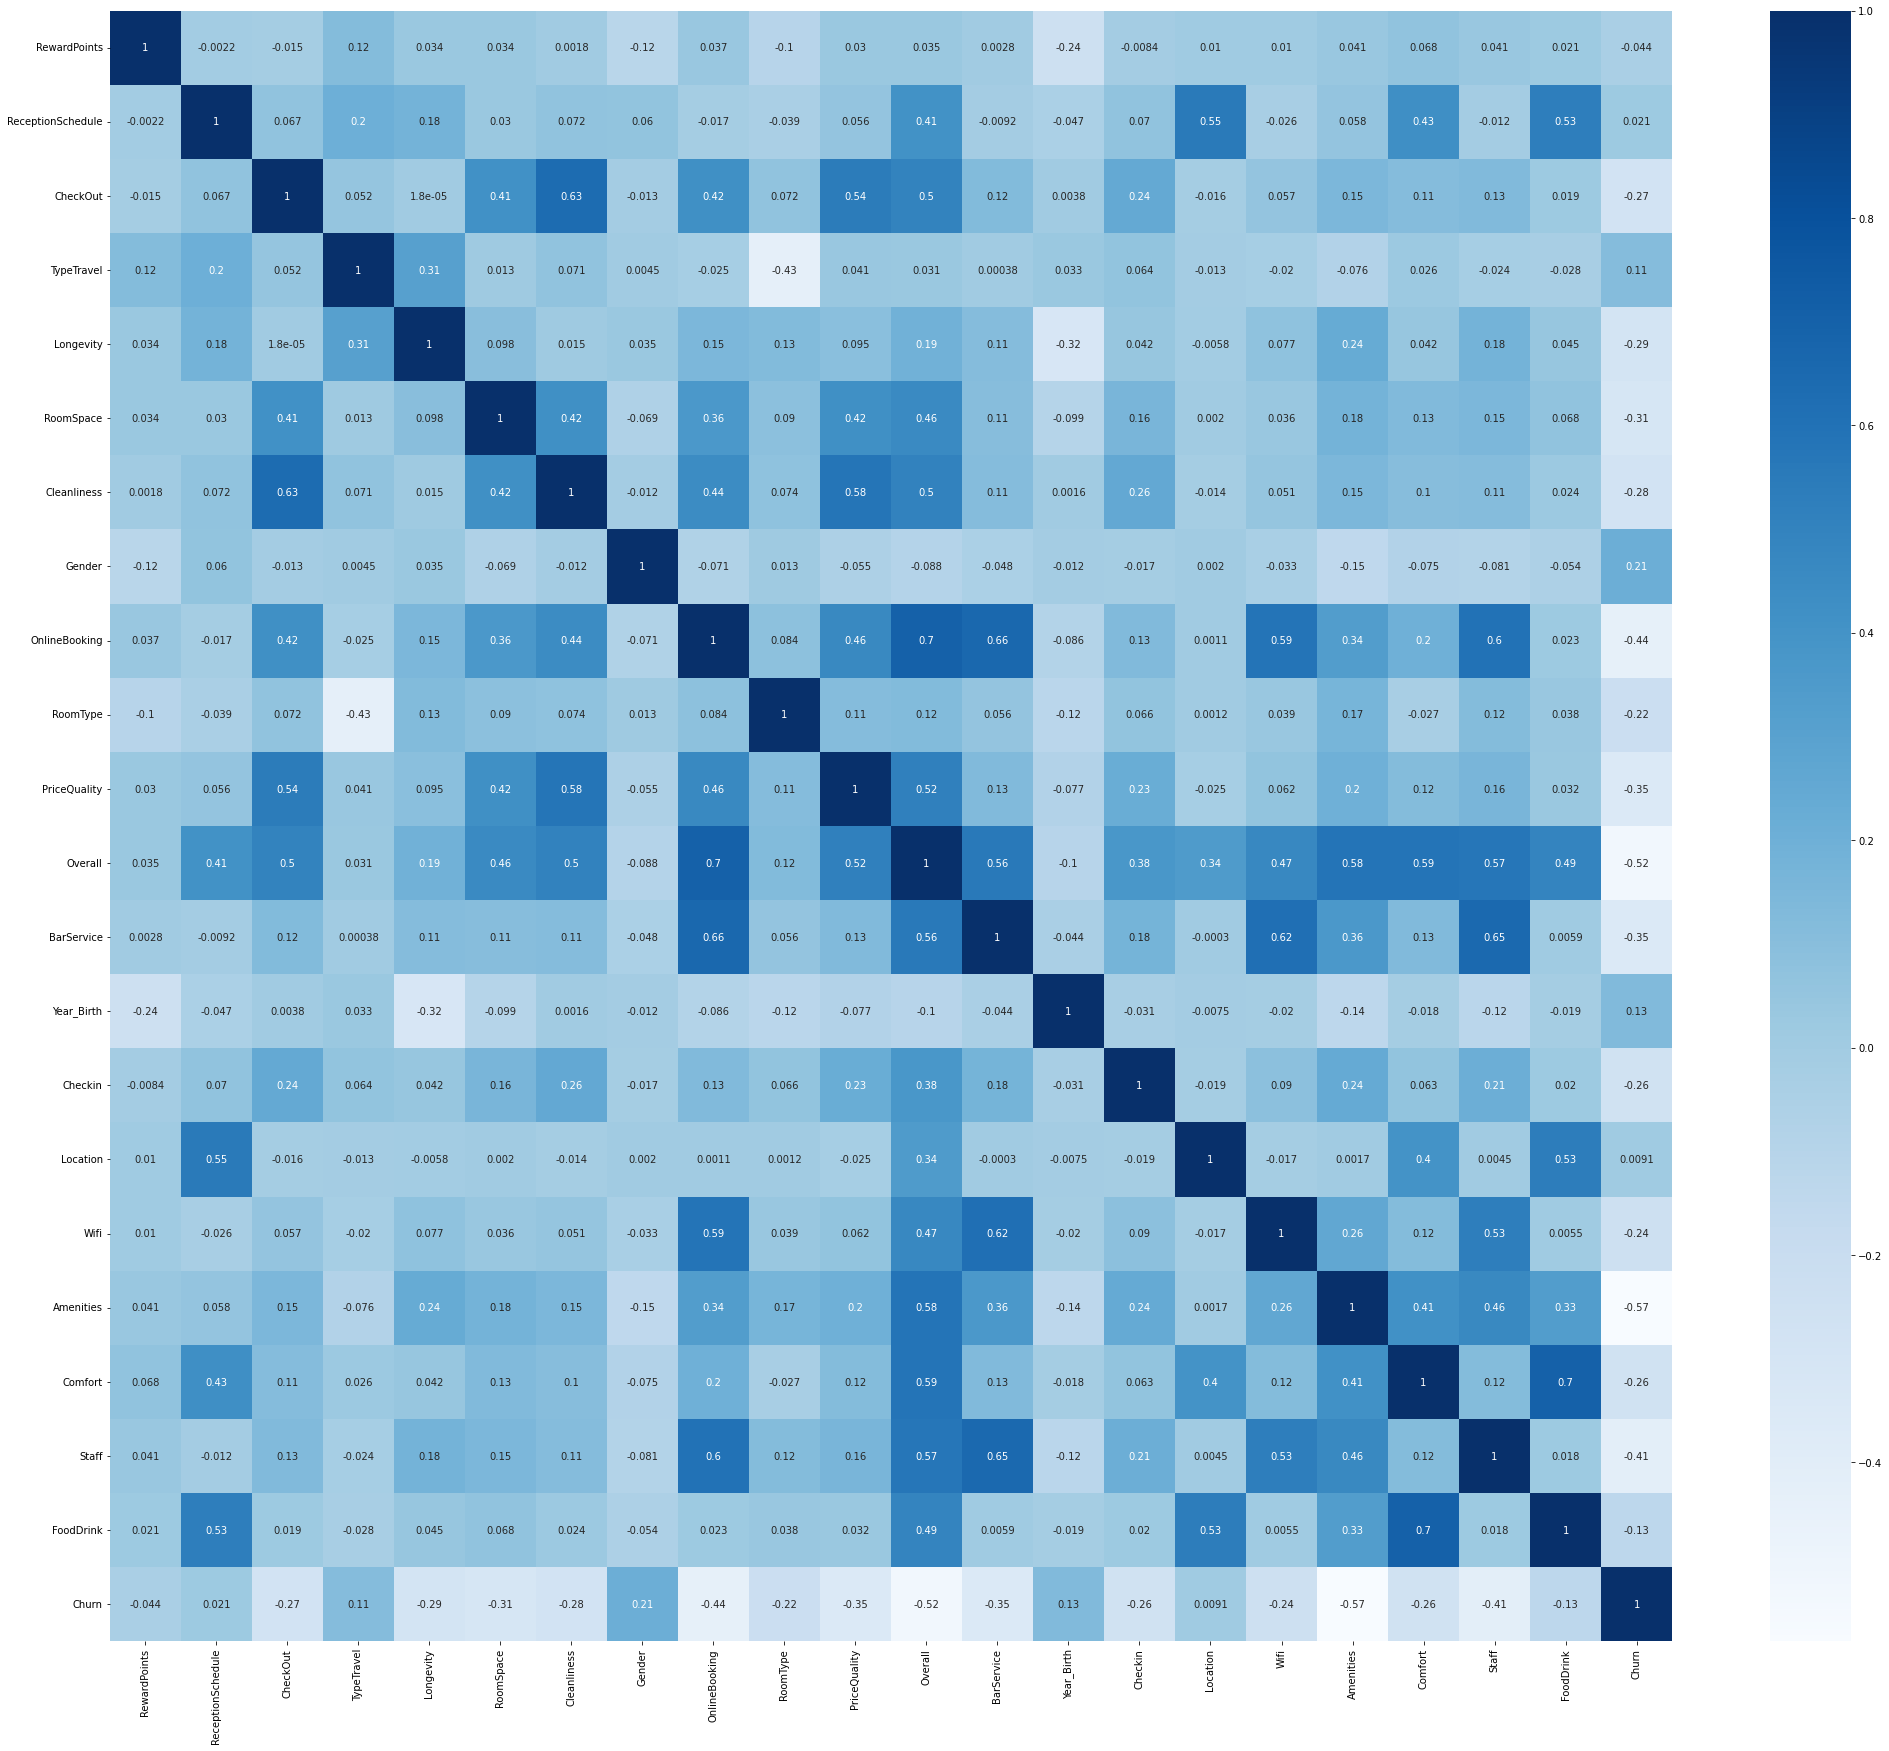

In [16]:
cor_spearman = df_feats.assign(Churn=df_target).corr(method ='spearman')

def cor_heatmap(cor):
    plt.figure(figsize=(35,30))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Blues)
    plt.show()

cor_heatmap(cor_spearman)

The maximum correlation found is 0.7 between Overall (enginnered) and OnlineBooking, the others as saw in previous report are not great enough to be considered correlated.

The biggest correlation to our target (Churn) is -0.57 that is the Amenities, which is also not great enough, so we will investigate more with other Filter Methods.

#### Chi-Square Filter

In [17]:
def TestIndependence(X, y, var, alpha=0.05):        
    dfObserved = pd.crosstab(y, X) 
    chi2, p, dof, expected = chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p < alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

for var in df_feats_cat:
    TestIndependence(df_feats_cat[var],df_target, var)

RoomType is IMPORTANT for Prediction
Gender is IMPORTANT for Prediction
Longevity is IMPORTANT for Prediction
TypeTravel is IMPORTANT for Prediction


All categorical features were considered important, so none will be discarted. For continuous data we will try a Wrapper Method

#### Wrapper Method - RFE (Recursive Feature Elimination)

Considering that we will use all 4 categorical features, we will now decide which numerical features we shall use.

In [18]:
def rfe(X, y, model):
    nof_list=np.arange(1,17)            
    high_score=0
#Variable to store the optimum features
    nof=0           
    score_list =[]
    for n in range(len(nof_list)):
        rfe = RFE(model, n_features_to_select=nof_list[n])
        X_rfe = rfe.fit_transform(X,y)
        model.fit(X_rfe,y)
        score = model.score(X_rfe, y)
        score_list.append(score)
    
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
    print("Optimum number of features: %d" %nof)
    print("Score with %d features: %f" % (nof, score))
    selected_features = pd.Series(rfe.support_, index = df_feats_num.columns)
    #print(selected_features)
    print(selected_features.sort_values())
rfe(df_feats_num,df_target,LogisticRegression())    

Optimum number of features: 16
Score with 16 features: 0.802383
RewardPoints         False
Overall               True
Checkin               True
CheckOut              True
RoomSpace             True
PriceQuality          True
OnlineBooking         True
Staff                 True
Amenities             True
Wifi                  True
Location              True
FoodDrink             True
ReceptionSchedule     True
Comfort               True
Year_Birth            True
Cleanliness           True
BarService            True
dtype: bool


In [19]:
df_feats_rfe = df_feats.drop("RewardPoints" ,axis= 1)

In [20]:
df_feats_rfe.head()

,ReceptionSchedule,CheckOut,TypeTravel,Longevity,RoomSpace,Cleanliness,Gender,OnlineBooking,RoomType,PriceQuality,Overall,BarService,Year_Birth,Checkin,Location,Wifi,Amenities,Comfort,Staff,FoodDrink
0,0.8,0.50,0.0,1.0,0.6,0.50,0.0,0.6,0.5,0.50,0.555556,0.8,0.487179,0.75,0.75,0.8,0.6,0.6,0.75,0.2
1,0.2,1.00,0.0,1.0,1.0,1.00,1.0,1.0,0.5,1.00,0.518519,0.4,0.371795,0.00,0.00,1.0,0.6,0.2,0.75,0.2
2,0.6,0.50,0.0,1.0,0.4,0.50,1.0,0.6,0.5,0.50,0.407407,0.2,0.474359,0.25,0.50,0.2,0.8,0.6,0.75,0.6
3,0.2,0.75,1.0,1.0,0.8,0.75,0.0,0.8,0.0,0.75,0.518519,0.6,0.730769,0.75,0.00,0.8,0.8,0.2,1.00,0.2
4,0.4,0.75,0.0,1.0,0.6,0.50,1.0,1.0,0.5,1.00,0.629630,1.0,0.679487,0.00,0.25,1.0,1.0,0.4,1.00,0.6


As the above example, if we chose Logistic Regression as our model, instead of using all numberical features we can decide to use just the top 5. But the final decision will be done later.

### Modeling

Here we need to split training dataset into training and validation datasets through Stratified K Fold. This way we can guarantee that similar separation between churn and non-churn classification in the training and validation dataset will be done through stratification. Also, using crossvalidation

In [21]:
#Adapting loop function that compare models and show results from class to our problem
def compare_models(X, y, model):
    skf = StratifiedKFold(n_splits = 5)
    score_train = []
    score_val = []
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        model.fit(X_train, y_train)
        predictions_train = model.predict(X_train)
        predictions_val = model.predict(X_val)
        score_train.append(f1_score(y_train, predictions_train))
        score_val.append(f1_score(y_val, predictions_val))

    avg_train = round(np.mean(score_train),3)
    avg_val = round(np.mean(score_val),3)
    std_train = round(np.std(score_train),2)
    std_val = round(np.std(score_val),2)

    return str(avg_train) + '+/-' + str(std_train),str(avg_val) + '+/-' + str(std_val)

In [22]:
def show_results(df, X, y, *args):
    count = 0
    for arg in args:
        avg_train, avg_test = compare_models(X, y, arg)
        df.iloc[count] = avg_train, avg_test
        count+=1
    
    return df

Now we will be training with different algorithms using all features first, then we will use RFE to improve some of those models.

(takes ~1min30sec to run)

In [51]:
model_LR = LogisticRegression()
model_KNN = KNeighborsClassifier()
model_DT = DecisionTreeClassifier()
model_RF = RandomForestClassifier()
model_MLP = MLPClassifier()
model_GNB = GaussianNB()

df = pd.DataFrame(columns = ['Train','Validation'], index = ['Logistic Regression','DecisionTreeClassifier','RF','KNN','MLP','GaussianNB'])
show_results(df, df_feats, df_target, model_LR, model_DT, model_RF, model_KNN, model_MLP, model_GNB)

,Train,Validation
Logistic Regression,0.814+/-0.0,0.813+/-0.01
DecisionTreeClassifier,1.0+/-0.0,0.897+/-0.01
RF,1.0+/-0.0,0.928+/-0.01
KNN,0.928+/-0.0,0.899+/-0.0
MLP,0.942+/-0.0,0.927+/-0.01
GaussianNB,0.799+/-0.0,0.798+/-0.01


RFE effect:

In [53]:
df = pd.DataFrame(columns = ['Train','Validation'], index = ['Logistic Regression','DecisionTreeClassifier','RF','KNN','MLP','GaussianNB'])
show_results(df, df_feats_rfe, df_target, model_LR, model_DT, model_RF, model_KNN, model_MLP, model_GNB)

,Train,Validation
Logistic Regression,0.816+/-0.0,0.815+/-0.01
DecisionTreeClassifier,1.0+/-0.0,0.898+/-0.01
RF,1.0+/-0.0,0.931+/-0.0
KNN,0.929+/-0.0,0.899+/-0.0
MLP,0.941+/-0.0,0.923+/-0.0
GaussianNB,0.797+/-0.0,0.796+/-0.01


To use the best model (RF in this case) to predict on the submission dataset, the same treatment done to the training dataset must be done first into the test dataset

In [25]:
df_test = feat_data(treat_data(df_test))
df_test.head()

,Cust_ID,Name,Longevity,Year_Birth,TypeTravel,RoomType,RewardPoints,Comfort,ReceptionSchedule,FoodDrink,...,Staff,OnlineBooking,PriceQuality,RoomSpace,CheckOut,Checkin,Cleanliness,BarService,Overall,Gender
0,30000,Mr. Brandon Aguirre,1,1956,1,0,5584,2,4,2,...,1,1,5,3,4,4,4,1,2.571429,1
1,30001,Mr. Mathew Howard,1,2004,1,0,5970,2,4,2,...,4,4,4,5,4,3,1,4,3.142857,1
2,30002,Mr. Brian Peters,0,1992,0,1,5122,5,4,4,...,1,2,5,5,5,3,4,2,3.500000,1
3,30003,Mr. Robert Henderson,1,1986,1,0,5297,4,5,4,...,3,3,3,5,5,3,4,3,3.714286,1
4,30004,Ms. Stephanie Drake,1,1970,0,0,6047,4,2,2,...,3,4,4,4,4,4,4,4,3.571429,0


The same features must also be used and scaled

In [26]:
X_test = scale_data(df_test.filter(df_feats))
X_test.head()

,RewardPoints,ReceptionSchedule,CheckOut,TypeTravel,Longevity,RoomSpace,Cleanliness,Gender,OnlineBooking,RoomType,...,Overall,BarService,Year_Birth,Checkin,Location,Wifi,Amenities,Comfort,Staff,FoodDrink
0,0.802058,0.8,0.75,1.0,1.0,0.6,0.75,1.0,0.2,0.0,...,0.365385,0.2,0.205479,0.75,0.4,0.2,0.4,0.4,0.00,0.4
1,0.857992,0.8,0.75,1.0,1.0,1.0,0.00,1.0,0.8,0.0,...,0.519231,0.8,0.863014,0.50,0.2,0.8,0.4,0.4,0.75,0.4
2,0.735111,0.8,1.00,0.0,0.0,1.0,0.75,1.0,0.4,0.5,...,0.615385,0.4,0.698630,0.50,0.6,0.4,0.8,1.0,0.00,0.8
3,0.760469,1.0,1.00,1.0,1.0,1.0,0.75,1.0,0.6,0.0,...,0.673077,0.6,0.616438,0.50,0.6,0.6,0.8,0.8,0.50,0.8
4,0.869149,0.4,0.75,0.0,1.0,0.8,0.75,0.0,0.8,0.0,...,0.634615,0.8,0.397260,0.75,0.4,1.0,0.8,0.8,0.50,0.4


In [27]:
X_test_rfe = scale_data(df_test.filter(df_feats_rfe))
X_test_rfe.head()

,ReceptionSchedule,CheckOut,TypeTravel,Longevity,RoomSpace,Cleanliness,Gender,OnlineBooking,RoomType,PriceQuality,Overall,BarService,Year_Birth,Checkin,Location,Wifi,Amenities,Comfort,Staff,FoodDrink
0,0.8,0.75,1.0,1.0,0.6,0.75,1.0,0.2,0.0,1.00,0.365385,0.2,0.205479,0.75,0.4,0.2,0.4,0.4,0.00,0.4
1,0.8,0.75,1.0,1.0,1.0,0.00,1.0,0.8,0.0,0.75,0.519231,0.8,0.863014,0.50,0.2,0.8,0.4,0.4,0.75,0.4
2,0.8,1.00,0.0,0.0,1.0,0.75,1.0,0.4,0.5,1.00,0.615385,0.4,0.698630,0.50,0.6,0.4,0.8,1.0,0.00,0.8
3,1.0,1.00,1.0,1.0,1.0,0.75,1.0,0.6,0.0,0.50,0.673077,0.6,0.616438,0.50,0.6,0.6,0.8,0.8,0.50,0.8
4,0.4,0.75,0.0,1.0,0.8,0.75,0.0,0.8,0.0,0.75,0.634615,0.8,0.397260,0.75,0.4,1.0,0.8,0.8,0.50,0.4


Applying the best 2 trained model to predict our 'Churn' clients on the test dataset to be submitted. Two datasets for each. One with the "rfe effect" and other with all features

Dataset with all features

In [28]:
model_RF = RandomForestClassifier()
model_RF.fit(df_feats, df_target)
y_test = model_RF.predict(X_test)
y_test

array([1, 1, 0, ..., 1, 1, 0], dtype=int64)

Predictions must be concatenated to the Client ID and submitted by CSV into Kaddle

In [29]:
df_pred = pd.concat([df_test['Cust_ID'],pd.DataFrame(y_test,columns = ['Churn'])],axis=1)
df_pred.to_csv('Group18_Version03.csv',index=False)
df_pred.head()

,Cust_ID,Churn
0,30000,1
1,30001,1
2,30002,0
3,30003,1
4,30004,0


Score at Kaggle: 0.93674

Dataset with rfe effect

In [30]:
model_RF.fit(df_feats_rfe, df_target)
y_test_rfe = model_RF.predict(X_test_rfe)
y_test

array([1, 1, 0, ..., 1, 1, 0], dtype=int64)

In [31]:
df_pred = pd.concat([df_test['Cust_ID'],pd.DataFrame(y_test_rfe,columns = ['Churn'])],axis=1)
df_pred.to_csv('Group18_Version07.csv',index=False)
df_pred.head()

,Cust_ID,Churn
0,30000,1
1,30001,1
2,30002,0
3,30003,1
4,30004,0


Score at Kaggle: 0.93277

Even overfitting the training dataset, the Random Forest Model were still able to achieve a good F1-Score in the test dataset at Kaggle. With "rfe effect" has lower score and the same overfitting value. So the best is with all features

Now let's submit the MLP model that has less overfitting.

First the dataset with all features:

In [32]:
model_MLP = MLPClassifier()
model_MLP.fit(df_feats, df_target)
y_test = model_MLP.predict(X_test)
y_test

array([1, 1, 0, ..., 1, 1, 0], dtype=int64)

In [33]:
df_pred = pd.concat([df_test['Cust_ID'],pd.DataFrame(y_test,columns = ['Churn'])],axis=1)
df_pred.to_csv('Group18_Version04.csv',index=False)
df_pred.head()

,Cust_ID,Churn
0,30000,1
1,30001,1
2,30002,0
3,30003,1
4,30004,0


Score at Kaggle: 0.93079

The dataset with rfe effect:

In [34]:
model_MLP.fit(df_feats_rfe, df_target)
y_test_rfe = model_MLP.predict(X_test_rfe)
y_test

array([1, 1, 0, ..., 1, 1, 0], dtype=int64)

In [35]:
df_pred = pd.concat([df_test['Cust_ID'],pd.DataFrame(y_test_rfe,columns = ['Churn'])],axis=1)
df_pred.to_csv('Group18_Version08.csv',index=False)
df_pred.head()

,Cust_ID,Churn
0,30000,1
1,30001,1
2,30002,0
3,30003,1
4,30004,0


Score at Kaggle: 0.92875

MLP with rfe effect has less kaggle score with more or less the same amount of overfitting. So we think thet the one with all features it's better. MLP has slightly less kaggle's score than RFE  (0.93079 and 0.93674), but less amount of overfitting

### Model Tunning

Now we will try to tune this best 2 models, RF and MLP by selecting better numerical features and applying GridSearch Method to tune the parameters, let's see if we can improve.

#### Improving RandomForest

Starting by iterating different parameters using GridSearch

(takes ~2min to run)

In [36]:
param_grid = {
    'criterion': ['gini','entropy'],
    'max_depth': [5, 20, 30],
    'n_estimators': [50, 200, 300]
}
grid_search = GridSearchCV(estimator = model_RF, param_grid = param_grid, verbose = 3, scoring='f1')

In [37]:
grid_search.fit(df_feats, df_target)
print(grid_search.best_params_)
print(grid_search.best_score_)
max_f1_score=grid_search.best_score_

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END criterion=gini, max_depth=5, n_estimators=50;, score=0.881 total time=   0.3s
[CV 2/5] END criterion=gini, max_depth=5, n_estimators=50;, score=0.881 total time=   0.3s
[CV 3/5] END criterion=gini, max_depth=5, n_estimators=50;, score=0.875 total time=   0.3s
[CV 4/5] END criterion=gini, max_depth=5, n_estimators=50;, score=0.887 total time=   0.2s
[CV 5/5] END criterion=gini, max_depth=5, n_estimators=50;, score=0.881 total time=   0.2s
[CV 1/5] END criterion=gini, max_depth=5, n_estimators=200;, score=0.883 total time=   1.1s
[CV 2/5] END criterion=gini, max_depth=5, n_estimators=200;, score=0.882 total time=   1.0s
[CV 3/5] END criterion=gini, max_depth=5, n_estimators=200;, score=0.871 total time=   0.9s
[CV 4/5] END criterion=gini, max_depth=5, n_estimators=200;, score=0.888 total time=   1.2s
[CV 5/5] END criterion=gini, max_depth=5, n_estimators=200;, score=0.881 total time=   1.1s
[CV 1/5] END criterion=g

Interesting it changed the default values of a RandomForest() to n_estimators=200 instead of 100 and max_depth=30 achieving a F1 score of 0.93, so let's submit it to Kaggle!

In [38]:
model_RF = RandomForestClassifier(max_depth=30,n_estimators=200)
model_RF.fit(df_feats, df_target)
y_test = model_RF.predict(X_test)
y_test
df_pred = pd.concat([df_test['Cust_ID'],pd.DataFrame(y_test,columns = ['Churn'])],axis=1)
df_pred.to_csv('Group18_Version05.csv',index=False)

It didn't improve, kaggle score was: 0.93423

Now we will try to select best 5 numerical features for RF and add to all categoricals that were seem as relevant with Chi-Squared Filter Method.

(takes ~45sec to run)

In [39]:
def rfe_rank(X, y, model):
    rfe = RFE(estimator = model, n_features_to_select = 1)
    X_rfe = rfe.fit_transform(X , y)
    ranking_features = pd.Series(rfe.ranking_, index = df_feats_num.columns)
    print(ranking_features.sort_values())
    
rfe_rank(df_feats_num,df_target,model_RF)

RewardPoints          1
Amenities             2
Comfort               3
Overall               4
Year_Birth            5
OnlineBooking         6
Staff                 7
FoodDrink             8
RoomSpace             9
PriceQuality         10
ReceptionSchedule    11
Location             12
BarService           13
Cleanliness          14
Checkin              15
Wifi                 16
CheckOut             17
dtype: int32


Training and evaluating with F1 the same tunned RF but with just best features

In [40]:
model_RF = RandomForestClassifier(criterion='entropy',max_depth=30,n_estimators=200)
df = pd.DataFrame(columns = ['Train','Validation'], index = ['RF'])
show_results(df, df_feats[['RoomType','Gender','Longevity','TypeTravel','Overall','Comfort','Amenities','Year_Birth','RewardPoints']], df_target, model_RF)

,Train,Validation
RF,1.0+/-0.0,0.898+/-0.0


Results were no better with top 5 numerical and all categorical features, so let's try to improve MLP.

#### Improving MLP

Same logic, starting by tunning parameters then chosing best features:

(takes ~10min to run, so we commented this GridSearch for MLP)

In [41]:
model_MLP = MLPClassifier()
param_grid = {
    'hidden_layer_sizes': [(10,),(100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'learning_rate': ['constant','adaptive'],
}
grid_search = GridSearchCV(model_MLP, param_grid = param_grid, verbose = 3, scoring='f1')

In [42]:
grid_search.fit(df_feats, df_target)
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END activation=tanh, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=0.834 total time=   3.9s
[CV 2/5] END activation=tanh, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=0.834 total time=   3.7s
[CV 3/5] END activation=tanh, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=0.821 total time=   4.0s
[CV 4/5] END activation=tanh, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=0.832 total time=   3.5s
[CV 5/5] END activation=tanh, hidden_layer_sizes=(10,), learning_rate=constant, solver=sgd;, score=0.835 total time=   4.4s
[CV 1/5] END activation=tanh, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=0.895 total time=   4.1s
[CV 2/5] END activation=tanh, hidden_layer_sizes=(10,), learning_rate=constant, solver=adam;, score=0.902 total time=   4.0s
[CV 3/5] END activation=tanh, hidden_layer_sizes=(10,), learning_rate

Only the learning rate parameter changed from default, now being adaptive instead of constant. Still the F1 Score in the training dataset didn't improve, so we submitted the previous MLP to Kaggle and acquired a F1-score of 0.93079.

However, let's try to improve even more this MLP selecting the best features. Since RFE method does not work with MLP, we will use SequentialFeatureSelector.

In [43]:
SFS=SFS(MLPClassifier(),k_features='best', forward=True,n_jobs=-1,verbose=1,cv=5) 
SFS=SFS.fit(df_feats, df_target)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:  1.2min finished
Features: 1/21[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.1min finished
Features: 2/21[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:  3.1min finished
Features: 3/21[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  4.6min finished
Features: 4/21[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:  4.2min finished
Features: 5/21[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  3.8min finished
Features: 6/21[Parallel(n_jobs=-1)]: Using backe

In [44]:
SFS.k_feature_idx_

(0, 1, 2, 3, 4, 6, 7, 9, 10, 11, 14, 15, 17, 18, 20)

In [45]:
df_feats.columns[0:][list(SFS.k_feature_idx_)]

Index(['RewardPoints', 'ReceptionSchedule', 'CheckOut', 'TypeTravel',
       'Longevity', 'Cleanliness', 'Gender', 'RoomType', 'PriceQuality',
       'Overall', 'Checkin', 'Location', 'Amenities', 'Comfort', 'FoodDrink'],
      dtype='object')

In [46]:
model_MLP = MLPClassifier(learning_rate='adaptive')
df = pd.DataFrame(columns = ['Train','Validation'], index = ['MLP'])
show_results(df, df_feats[['Year_Birth', 'Staff', 'Overall', 'RoomSpace', 'BarService', 'Gender',
       'ReceptionSchedule', 'RoomType', 'TypeTravel', 'Comfort', 'Longevity',
       'CheckOut', 'Location', 'Cleanliness', 'OnlineBooking', 'Amenities',
       'RewardPoints', 'FoodDrink']], df_target, model_MLP)

,Train,Validation
MLP,0.94+/-0.0,0.927+/-0.0


In [47]:
selected = {'Year_Birth', 'Staff', 'Overall', 'RoomSpace', 'BarService', 'Gender',
       'ReceptionSchedule', 'RoomType', 'TypeTravel', 'Comfort', 'Longevity',
       'CheckOut', 'Location', 'Cleanliness', 'OnlineBooking', 'Amenities',
       'RewardPoints', 'FoodDrink'}
df_selected = df_feats.filter(selected)
df_selected.head()

,RewardPoints,ReceptionSchedule,CheckOut,TypeTravel,Longevity,RoomSpace,Cleanliness,Gender,OnlineBooking,RoomType,Overall,BarService,Year_Birth,Location,Amenities,Comfort,Staff,FoodDrink
0,0.687662,0.8,0.50,0.0,1.0,0.6,0.50,0.0,0.6,0.5,0.555556,0.8,0.487179,0.75,0.6,0.6,0.75,0.2
1,0.965449,0.2,1.00,0.0,1.0,1.0,1.00,1.0,1.0,0.5,0.518519,0.4,0.371795,0.00,0.6,0.2,0.75,0.2
2,0.604800,0.6,0.50,0.0,1.0,0.4,0.50,1.0,0.6,0.5,0.407407,0.2,0.474359,0.50,0.8,0.6,0.75,0.6
3,0.525913,0.2,0.75,1.0,1.0,0.8,0.75,0.0,0.8,0.0,0.518519,0.6,0.730769,0.00,0.8,0.2,1.00,0.2
4,0.759364,0.4,0.75,0.0,1.0,0.6,0.50,1.0,1.0,0.5,0.629630,1.0,0.679487,0.25,1.0,0.4,1.00,0.6


In [48]:
X_test_selected = scale_data(df_test.filter(df_selected))#changed
X_test_selected.head()

,RewardPoints,ReceptionSchedule,CheckOut,TypeTravel,Longevity,RoomSpace,Cleanliness,Gender,OnlineBooking,RoomType,Overall,BarService,Year_Birth,Location,Amenities,Comfort,Staff,FoodDrink
0,0.802058,0.8,0.75,1.0,1.0,0.6,0.75,1.0,0.2,0.0,0.365385,0.2,0.205479,0.4,0.4,0.4,0.00,0.4
1,0.857992,0.8,0.75,1.0,1.0,1.0,0.00,1.0,0.8,0.0,0.519231,0.8,0.863014,0.2,0.4,0.4,0.75,0.4
2,0.735111,0.8,1.00,0.0,0.0,1.0,0.75,1.0,0.4,0.5,0.615385,0.4,0.698630,0.6,0.8,1.0,0.00,0.8
3,0.760469,1.0,1.00,1.0,1.0,1.0,0.75,1.0,0.6,0.0,0.673077,0.6,0.616438,0.6,0.8,0.8,0.50,0.8
4,0.869149,0.4,0.75,0.0,1.0,0.8,0.75,0.0,0.8,0.0,0.634615,0.8,0.397260,0.4,0.8,0.8,0.50,0.4


In [49]:
model_MLP.fit(df_selected, df_target)
y_test_selected = model_MLP.predict(X_test_selected)
y_test_selected

array([1, 1, 0, ..., 1, 1, 0], dtype=int64)

In [50]:
df_pred = pd.concat([df_test['Cust_ID'],pd.DataFrame(y_test_selected,columns = ['Churn'])],axis=1)
df_pred.to_csv('Group18_Version09.csv',index=False)
df_pred.head()

,Cust_ID,Churn
0,30000,1
1,30001,1
2,30002,0
3,30003,1
4,30004,0


Score at Kaggle:  0.92315

It didn't achieve better results selecting specific features to train the MLP. So we will keep the same best 2 models so far.

### Conclusion

The best two models achieved were:

1) Random Forest - Kaggle as Group18_Version03.csv with a F1-Score of 0.93423.
2) MLP - Kaggle as Group18_Version04.csv with a F1-Score of 0.93079.

Even after performing a feature selection with Filter (Spearman + Chi-Square) and Wrapper (RFE and Sequential Feature Selector) Methods, both models have the best performance using all features including 2 of them that was created "Overall" and "Gender".

Even after performing a parameter tunning with GridSearch, both models have the best performance using the default parameters.

Model 1 has a lot of overfitting (1.0) in the training dataset and might not be good option to be used in big unseen datasets since it might just me memorizing the results.

Model 2, even with less F1-score has similar score for training and validation dataset from crossfold validation, not characterizing overfitting and should be a better choice in big unseen datasets.